In [11]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
import MENDER
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from scipy import stats
import re
import os
import glob
import tifffile
import pandas as pd
from skimage.measure import regionprops_table
import numpy as np

path_to_dataset = r"tnbc.h5ad"

# Generate spatial coordinates

In [5]:


# Directory containing your segmented mask TIFF files
mask_dir = r'TNBC_shareCellData'
# Output CSV file path
output_csv = "cell_centroids.csv"

records = []

# Loop through each TIFF mask
for mask_path in glob.glob(os.path.join(mask_dir, "*.tiff")):
    # Load the mask (each cell labeled by a unique integer)
    mask = tifffile.imread(mask_path)

    print("Shape:", mask.shape)          # e.g. (1024, 1024)
    print("Data type:", mask.dtype)      # e.g. uint16
    labels = np.unique(mask)
    print(f"Found {len(labels)-1} objects (ignoring background=0)")
    print("Some label values:", labels[:10], "…", labels[-10:])
    # Extract properties: label ID and centroids
    props = regionprops_table(
        mask,
        properties=('label', 'centroid')
    )
    
    # Convert to DataFrame
    df = pd.DataFrame(props)
    # Keep track of source image
    
    
    nums = re.search(r"\d+", os.path.basename(mask_path))
    df['image'] = int(nums.group()) if nums else None
    records.append(df)

# Concatenate all image DataFrames
all_cells = pd.concat(records, ignore_index=True)

# Rename columns for clarity
all_cells = all_cells.rename(
    columns={
        'label': 'CellID',
        'centroid-0': 'CentroidY',
        'centroid-1': 'CentroidX'
    }
)

# Save to CSV
all_cells.to_csv(output_csv, index=False)
print(f"Saved {len(all_cells)} cell centroids to {output_csv}")


Shape: (2048, 2048)
Data type: uint16
Found 5213 objects (ignoring background=0)
Some label values: [0 1 2 3 4 5 6 7 8 9] … [5204 5205 5206 5207 5208 5209 5210 5211 5212 5213]
Shape: (2048, 2048)
Data type: uint16
Found 6140 objects (ignoring background=0)
Some label values: [0 1 2 3 4 5 6 7 8 9] … [6131 6132 6133 6134 6135 6136 6137 6138 6139 6140]
Shape: (2048, 2048)
Data type: uint16
Found 8772 objects (ignoring background=0)
Some label values: [0 1 2 3 4 5 6 7 8 9] … [8763 8764 8765 8766 8767 8768 8769 8770 8771 8772]
Shape: (2048, 2048)
Data type: uint16
Found 9738 objects (ignoring background=0)
Some label values: [0 1 2 3 4 5 6 7 8 9] … [9729 9730 9731 9732 9733 9734 9735 9736 9737 9738]
Shape: (2048, 2048)
Data type: uint16
Found 7751 objects (ignoring background=0)
Some label values: [0 1 2 3 4 5 6 7 8 9] … [7742 7743 7744 7745 7746 7747 7748 7749 7750 7751]
Shape: (2048, 2048)
Data type: uint16
Found 3560 objects (ignoring background=0)
Some label values: [0 1 2 3 4 5 6 7 8 9

In [7]:
df = pd.read_csv("TNBC_shareCellData/cellData.csv", sep=",") 
df_p = pd.read_csv("TNBC_shareCellData/patient_class.csv", header=None)
df_p.rename(columns={0:"SampleID", 1:"subtype"}, inplace=True)
subtype_map = {
    0: "Mixed",
    1: "Compartimentalized",
    2: "Cold"
}

df_p["subtype"] = df_p["subtype"].map(subtype_map).astype('category')




bad_Values = [42,43,44]
df = df[~df["SampleID"].isin(bad_Values)]


meta_cols = ['SampleID', 'cellLabelInImage', 'cellSize', 'tumorYN', 
             'tumorCluster', 'Group', 'immuneCluster', 'immuneGroup']

expr_cols = [c for c in df.columns if c not in meta_cols]

adata = AnnData(
    X = df[expr_cols].values,
    obs = df[meta_cols],
    var=pd.DataFrame(index=expr_cols)
)

adata.obs["UniqueID"] = adata.obs['SampleID'].astype(str) + "_" + adata.obs['cellLabelInImage'].astype(str)
all_cells["UniqueID"] = all_cells["image"].astype(str) + "_" + all_cells["CellID"].astype(str)
all_cells = all_cells.set_index('UniqueID', drop = False)
adata.obs = adata.obs.set_index('UniqueID', drop=False)

all_cells_aligned = all_cells.reindex(adata.obs_names)

adata.obsm["spatial"] = all_cells_aligned[["CentroidX", "CentroidY"]].to_numpy()

# X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
# min_val = X.min()
# print("Minimum before shift:", min_val)

# 2. If it’s < 0, shift everything up so the minimum is 0
# if min_val < 0:
#     shift = -min_val
#     print(f"Shifting all values by +{shift:.3g} to eliminate negatives")
#     X += shift
#     adata.X = X  # put it back into your AnnData

# sc.pp.normalize_total(adata)         # e.g. counts per cell
# sc.pp.log1p(adata)
# sc.pp.scale(adata)

# sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
# sc.pp.neighbors(adata)               # builds graph on PCA
# sc.tl.umap(adata)
code2label_group = {
    1: "Unidentified",
    2: "Immune",
    3: "EndoThelial",
    4: "Mesenchymal-like",
    5: "Tumor",
    6: "Keratin-positive tumor"
}

code2label_immunegroup = {
    1: "Tregs",
    2: "CD4 T",
    3: "CD8 T",
    4: "CD3 T",
    5: "NK",
    6: "B",
    7: "Neutrophils",
    8: "Macrophages",
    9: "DC",
    10: "DC/Mono",
    11: "Mono/Neu",
    12: "Other immune"
}
adata.obs["Group"] = adata.obs["Group"].map(code2label_group).astype('category')
adata.obs["immuneGroup"] = adata.obs["immuneGroup"].map(code2label_immunegroup)
adata.obs = pd.merge(
    adata.obs,
    df_p,
    on="SampleID",
    how="left"
)
adata.obs

c:\Users\chris\anaconda3\envs\ml_for_bio_3.9\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,SampleID,cellLabelInImage,cellSize,tumorYN,tumorCluster,Group,immuneCluster,immuneGroup,UniqueID,subtype
0,1,2,146,1,0,Keratin-positive tumor,0,NaN,1_2,Mixed
1,1,3,102,0,0,Immune,46,CD3 T,1_3,Mixed
2,1,4,43,1,0,Keratin-positive tumor,0,NaN,1_4,Mixed
3,1,5,211,1,0,Keratin-positive tumor,0,NaN,1_5,Mixed
4,1,6,177,0,0,Immune,75,B,1_6,Mixed
...,...,...,...,...,...,...,...,...,...,...
197673,41,5093,90,1,0,Keratin-positive tumor,0,NaN,41_5093,Compartimentalized
197674,41,5094,132,1,21,Tumor,0,NaN,41_5094,Compartimentalized
197675,41,5095,123,0,0,Immune,31,Macrophages,41_5095,Compartimentalized
197676,41,5096,99,0,0,Immune,56,Other immune,41_5096,Compartimentalized


In [8]:
print(adata.var_names)

Index(['C', 'Na', 'Si', 'P', 'Ca', 'Fe', 'dsDNA', 'Vimentin', 'SMA',
       'Background', 'B7H3', 'FoxP3', 'Lag3', 'CD4', 'CD16', 'CD56', 'OX40',
       'PD1', 'CD31', 'PD-L1', 'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138',
       'CD163', 'CD68', 'CSF-1R', 'CD8', 'CD3', 'IDO', 'Keratin17', 'CD63',
       'CD45RO', 'CD20', 'p53', 'Beta catenin', 'HLA-DR', 'CD11b', 'CD45',
       'H3K9ac', 'Pan-Keratin', 'H3K27me3', 'phospho-S6', 'MPO', 'Keratin6',
       'HLA_Class_1', 'Ta', 'Au'],
      dtype='object')


In [9]:
print(adata.obsm['spatial'].shape)

(197678, 2)


Sample IDs: [5, 13]
Plotting SampleID: 5


c:\Users\chris\anaconda3\envs\ml_for_bio_3.9\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\chris\anaconda3\envs\ml_for_bio_3.9\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


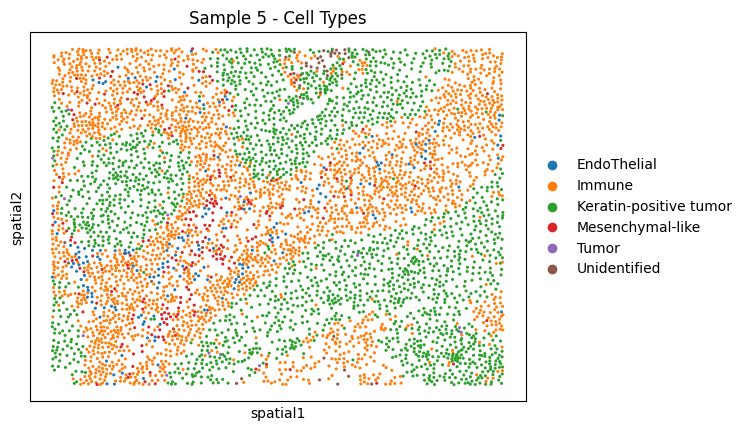

Plotting SampleID: 13


c:\Users\chris\anaconda3\envs\ml_for_bio_3.9\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\chris\anaconda3\envs\ml_for_bio_3.9\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


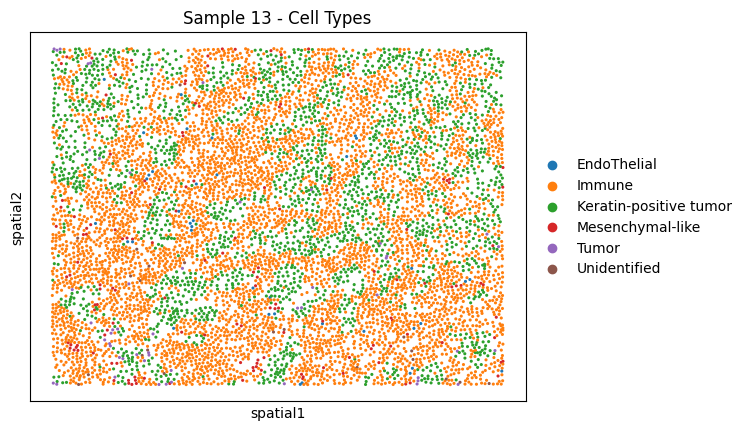

In [10]:
sample_ids = adata.obs['SampleID'].unique()

# 5 AND 13 ARE THE ONES THEY USE IN THE PAPER FIGURES!!!
sample_ids = [5, 13]
print("Sample IDs:", sample_ids)
# subtypes = ['Mixed', 'Compartmentalized']
# for subtype in subtypes:
#     print(f"Plotting subtype: {subtype}")
#     adata_slice = adata[adata.obs['subtype'] == subtype].copy()
#     # Create the plot
#     ax = sc.pl.embedding(
#         adata_slice,
#         basis='spatial',
#         color='all_group_name',
#         title=f"Sample {subtype} - Cell Types",
#         size=20,
#         show=False  # Prevents showing immediately
#     )
#
#     # Flip the Y-axis (THIS IS WHAT THEY HAVE IN THE PAPER FOR SOME REASON)
#     plt.gca().invert_yaxis()
#
#     # Now show the modified plot
#     plt.show()

for sample_id in sample_ids:
    print(f"Plotting SampleID: {sample_id}")
    adata_slice = adata[adata.obs['SampleID'] == sample_id].copy()

    # Create the plot
    ax = sc.pl.embedding(
        adata_slice,
        color='Group',
        basis='spatial',
        title=f"Sample {sample_id} - Cell Types",
        size=20,
        show=False  # Prevents showing immediately
    )

    # Flip the Y-axis (THIS IS WHAT THEY HAVE IN THE PAPER FOR SOME REASON)
    plt.gca().invert_yaxis()

    # Now show the modified plot
    plt.show()


In [ ]:
adata_raw = adata.copy()
batch_obs = 'subtype'
scale = 6
radius = 15

# I'm not sure why they did so many copies but I took it from this code 
# https://mender-tutorial.readthedocs.io/en/latest/MERSCOPE.html
adata = adata_raw.copy()

# adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

# Only do it for these 18 samples to make it run more quickly. 6 mixed, comp and cold
sample_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 19, 22, 24, 25, 26]
adata = adata[adata.obs['SampleID'].isin(sample_ids)].copy()



# main body of MENDER
msm = MENDER.MENDER(
    adata,
    batch_obs = batch_obs,
    # determine which cell state to use
    # In our case the cell type does not need to be estimated since we have a ground truth stored in 
    # the dataset under all_group_name
    ct_obs= 'Group',
    random_seed=42,
    verbose=True
)


# set the MENDER parameters


msm.prepare()
msm.set_MENDER_para(
    # default of n_scales is 6
    n_scales=scale,

    # for single cell data, nn_mode is set to 'radius'
    nn_mode='radius',

    # default of n_scales is 15 um (see the manuscript for why).
    # MENDER also provide a function 'estimate_radius' for estimating the radius
    nn_para=radius,
)


# construct the context representation
msm.run_representation_mp(
    8
    # the number of processings
)

# set the spatial clustering parameter
# positive values for the expected number of domains
# negative values for the clustering resolution
msm.run_clustering_normal(-1.5)
# msm.run_clustering_normal(9)
msm.adata_MENDER.obs


c:\venvs\Mender\mender\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\venvs\Mender\mender\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


default number of process is 200


c:\venvs\Mender\mender\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


,SampleID,cellLabelInImage,cellSize,tumorYN,tumorCluster,Group,immuneCluster,immuneGroup,UniqueID,subtype,batch,MENDER_leiden_res1.5,MENDER
75864-0,15,2,389,1,0,Keratin-positive tumor,0,NaN,15_2,Cold,0,0,0
75865-0,15,3,194,1,0,Keratin-positive tumor,0,NaN,15_3,Cold,0,0,0
75866-0,15,4,317,1,0,Keratin-positive tumor,0,NaN,15_4,Cold,0,16,16
75867-0,15,5,555,1,0,Keratin-positive tumor,0,NaN,15_5,Cold,0,2,2
75868-0,15,6,172,1,0,Keratin-positive tumor,0,NaN,15_6,Cold,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69589-2,13,9734,64,0,0,Immune,59,CD8 T,13_9734,Mixed,2,11,11
69590-2,13,9735,46,0,0,Immune,56,Other immune,13_9735,Mixed,2,11,11
69591-2,13,9736,43,1,14,Mesenchymal-like,0,NaN,13_9736,Mixed,2,7,7
69592-2,13,9737,69,0,0,Immune,46,CD3 T,13_9737,Mixed,2,5,5


In [20]:
#sanity check
import numpy as np
list = msm.adata_MENDER.obs["SampleID"].unique()
print(np.sort(list))
list2 = adata.obs["SampleID"].unique()
print(np.sort(list2))

[ 1  2  3  4  5  6  7  8  9 10 11 13 15 19 22 24 25 26]
[ 1  2  3  4  5  6  7  8  9 10 11 13 15 19 22 24 25 26]


In [21]:
#sanity check
adata.obs.columns

Index(['SampleID', 'cellLabelInImage', 'cellSize', 'tumorYN', 'tumorCluster',
       'Group', 'immuneCluster', 'immuneGroup', 'UniqueID', 'subtype'],
      dtype='object')

# Data prep CT-coarse, CT-fine and Mender

In [30]:
# todo what if a patient does not contain all cell types?, no problem if we have all the patients here I think
# todo we should probably normalize the counts, idk if they do this but makes sense right since not every patient has the same number of cells or do they?

counts = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'MENDER']).size().unstack(fill_value=0)
)
X = counts.div(counts.sum(axis=1), axis=0)
# counts_type = (
#     msm.adata_MENDER.obs.groupby(['SampleID', 'all_group_name']).size().unstack(fill_value=0)
# )
# print(counts_type)
# X = pd.concat([counts, counts_type], axis=1, keys=['domain', 'cell_type']).reset_index()
#X = X.drop(columns=['MENDER'])
X_values = X.values
X_values

array([[0.00000000e+00, 1.04509386e-02, 0.00000000e+00, 1.48248500e-01,
        9.09618734e-03, 4.31585059e-02, 0.00000000e+00, 1.17282756e-01,
        1.50183859e-01, 1.11670215e-01, 8.59299400e-02, 9.13489452e-02,
        5.05128701e-02, 1.41281208e-01, 9.09618734e-03, 2.03212696e-02,
        0.00000000e+00, 1.16121541e-03, 9.87033095e-03, 0.00000000e+00,
        0.00000000e+00, 3.87071802e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 6.93527081e-03, 0.00000000e+00, 1.74042272e-01,
        3.96301189e-03, 5.35006605e-02, 0.00000000e+00, 1.28797886e-01,
        1.58850727e-01, 1.25825627e-01, 9.54425363e-02, 9.54425363e-02,
        4.75561427e-02, 7.33157199e-02, 7.59577279e-03, 1.58520476e-02,
        0.00000000e+00, 1.65125495e-03, 1.02377807e-02, 0.00000000e+00,
        6.60501982e-04, 3.30250991e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 1.68329375e-01, 0.00000000e+00, 4.56057007e-02,
        1.5613

In [31]:
y = msm.adata_MENDER.obs.groupby(['SampleID'])['subtype'].first().reset_index() # I can do this since each patient only has one subtype
y = y.drop(columns=['SampleID']).values.ravel()
y

array(['Mixed', 'Mixed', 'Compartimentalized', 'Compartimentalized',
       'Compartimentalized', 'Compartimentalized', 'Mixed', 'Mixed',
       'Compartimentalized', 'Compartimentalized', 'Mixed', 'Mixed',
       'Cold', 'Cold', 'Cold', 'Cold', 'Cold', 'Cold'], dtype=object)

## knn and svm for mender repr

In [32]:
knn = KNeighborsClassifier()
scores_knn = cross_val_score(knn, X_values, y, scoring='accuracy', cv=5)
print(scores_knn)

[1. 1. 1. 1. 1.]


In [33]:
svc = svm.SVC()
scores_svc = cross_val_score(svc, X_values, y, scoring='accuracy', cv=5)
print(scores_svc)

[1. 1. 1. 1. 1.]


In [26]:

# not really sure but maybe we need to use all_group_name and all_group_name2
X1 = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'immuneGroup']).size().unstack(fill_value=0)
).reset_index()
X1 = X1.drop(columns=['SampleID'])
X1 = X1.div(X1.sum(axis=1), axis=0) # todo maybe delete all_group_name column as well
X2 = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'Group']).size().unstack(fill_value=0)
).reset_index()
X2 = X2.drop(columns=['SampleID'])
X2 = X2.div(X2.sum(axis=1),axis=0) # todo maybe delete all_group_name column as well
X2

Group,EndoThelial,Immune,Keratin-positive tumor,Mesenchymal-like,Tumor,Unidentified
0,0.006774,0.495065,0.481517,0.008322,0.000194,0.008129
1,0.033025,0.315720,0.605680,0.042933,0.000330,0.002312
2,0.017736,0.503405,0.356136,0.116390,0.003642,0.002692
3,0.019871,0.626374,0.252898,0.032214,0.064579,0.004064
4,0.036256,0.516093,0.393082,0.043655,0.002775,0.008139
5,0.018339,0.386796,0.557686,0.021674,0.002334,0.013171
6,0.001173,0.163636,0.748094,0.033724,0.023754,0.029619
7,0.000319,0.178890,0.471620,0.117666,0.182717,0.048788
8,0.012217,0.532986,0.430363,0.008796,0.008308,0.007330
9,0.008734,0.625764,0.327511,0.032533,0.000655,0.004803


In [34]:
# all group name
knn = KNeighborsClassifier()
# knn.fit()

scores_knn_x1 = cross_val_score(knn, X1, y, scoring='accuracy', cv=5)
print(scores_knn_x1)

# all group name 2
knn = KNeighborsClassifier()
# knn.fit()

scores_knn_x2 = cross_val_score(knn, X2, y, scoring='accuracy', cv=5)
print(scores_knn_x2)


[0.5        0.75       0.5        0.33333333 0.33333333]
[0.75       0.75       0.75       1.         0.66666667]


In [35]:
# all group name
svc = svm.SVC()
scores_svc_x1 = cross_val_score(svc, X1, y, scoring='accuracy', cv=5)
print(scores_svc_x1)

# all group name2
svc = svm.SVC()
scores_svc_x2 = cross_val_score(svc, X2, y, scoring='accuracy', cv=5)
print(scores_svc_x2)

[0.5        0.25       0.5        0.33333333 0.66666667]
[0.75       0.25       0.5        1.         0.66666667]


In [36]:
print(stats.ttest_ind(scores_knn, scores_knn_x1))
print(stats.ttest_ind(scores_knn, scores_knn_x2))

Ttest_indResult(statistic=6.764754597315762, pvalue=0.00014287732826964825)
Ttest_indResult(statistic=3.833490860027325, pvalue=0.004993103459673324)


C:\Users\luket\AppData\Local\Temp\ipykernel_23376\401047906.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(stats.ttest_ind(scores_knn, scores_knn_x1))
C:\Users\luket\AppData\Local\Temp\ipykernel_23376\401047906.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(stats.ttest_ind(scores_knn, scores_knn_x2))


In [ ]:
# plt.bar()

/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


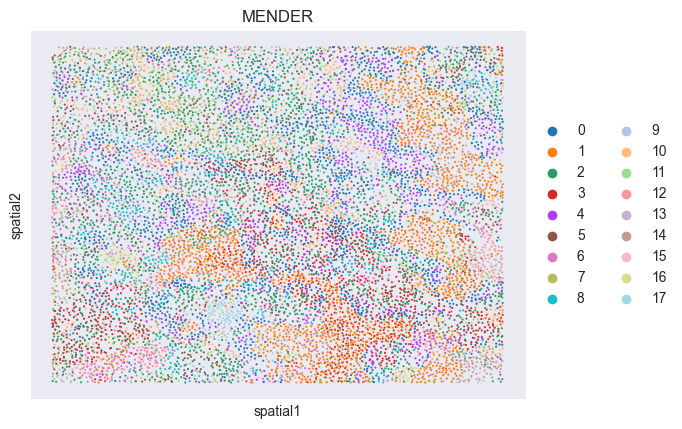

/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


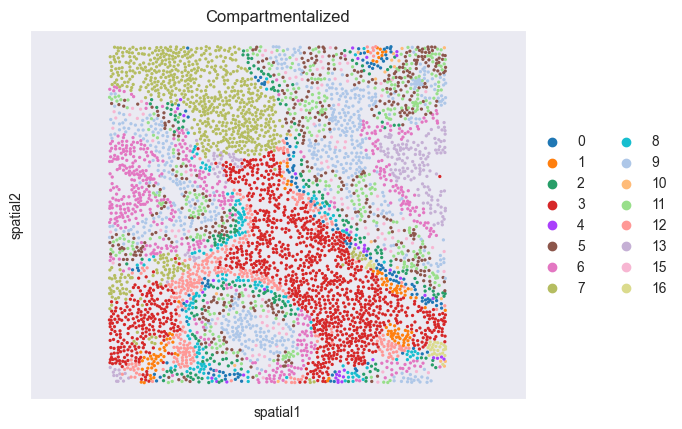

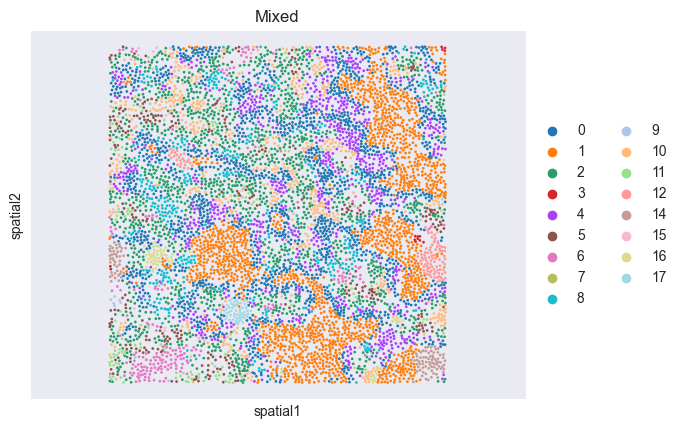

In [ ]:
msm.output_cluster_all(obs='MENDER',obs_gt=None)
# plt.gca().invert_yaxis()
plt.show()